## Run this script on a GPU

In [1]:
import jax
print("jax version:", jax.__version__)
print("Devices:", jax.devices())

jax version: 0.4.25
Devices: [cuda(id=0)]


In [2]:
import pandas as pd

df = pd.read_csv("data/df_indi_works_category.csv", index_col=0)
#df = pd.read_csv("data/df_indi_works_clean_gdp.csv", index_col=0)

print(len(df))

regions = pd.read_csv('data/ENS - Cultural Index - Countries Databases - region_level.csv')
regions['region_name'][regions['region_name']=='Slav world'] = 'East Slavic'


regions = regions[regions['level'] == 2]
regions = set(regions['region_name'])
df = df[df['region_name'].isin(regions)]
df["century"] = df["decade"].round(-2)
#df = df[df[df['region_name']=='']


df = df[~((df["region_name"] == "Italy") & (df["decade"] < 500))]


120069


/tmp/ipykernel_3459912/3088959021.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regions['region_name'][regions['region_name']=='Slav world'] = 'East Slavic'


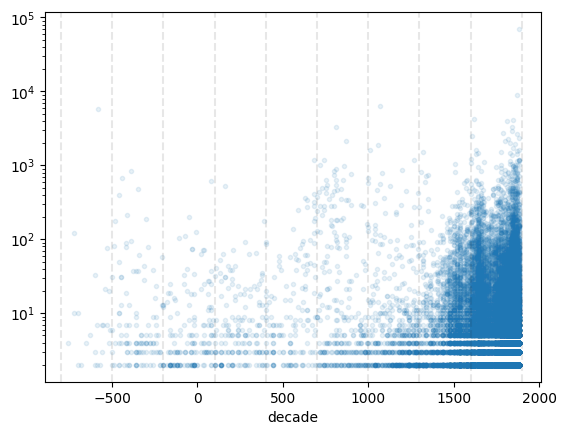

In [3]:
import matplotlib.pyplot as plt
import numpy as np

num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)

fig, ax = plt.subplots()
(df.groupby(["decade", "individual_wikidata_id"])["count_works"].sum() + 1).droplevel(
    level="individual_wikidata_id").plot(style=".", alpha=0.1, logy=True, ax=ax)

for knot in knots:
    ax.axvline(knot, color="0.1", alpha=0.1, ls="--")

In [4]:
df['count'] = df['count_works']
df_m = df.copy()
df_m = df_m[df_m['count'].isin({0, 1, 2})] # Not more ?
df_m['y'] = df_m['count'].map({0: 0, 1: 0, 2: 1})

# about 6% of women compared to men
df_m = df_m[df_m['decade']<1880]


Plot the global probability of observing a producer twice in the dataset, i.e. $p(n_{\text{obs}} = 2)$:

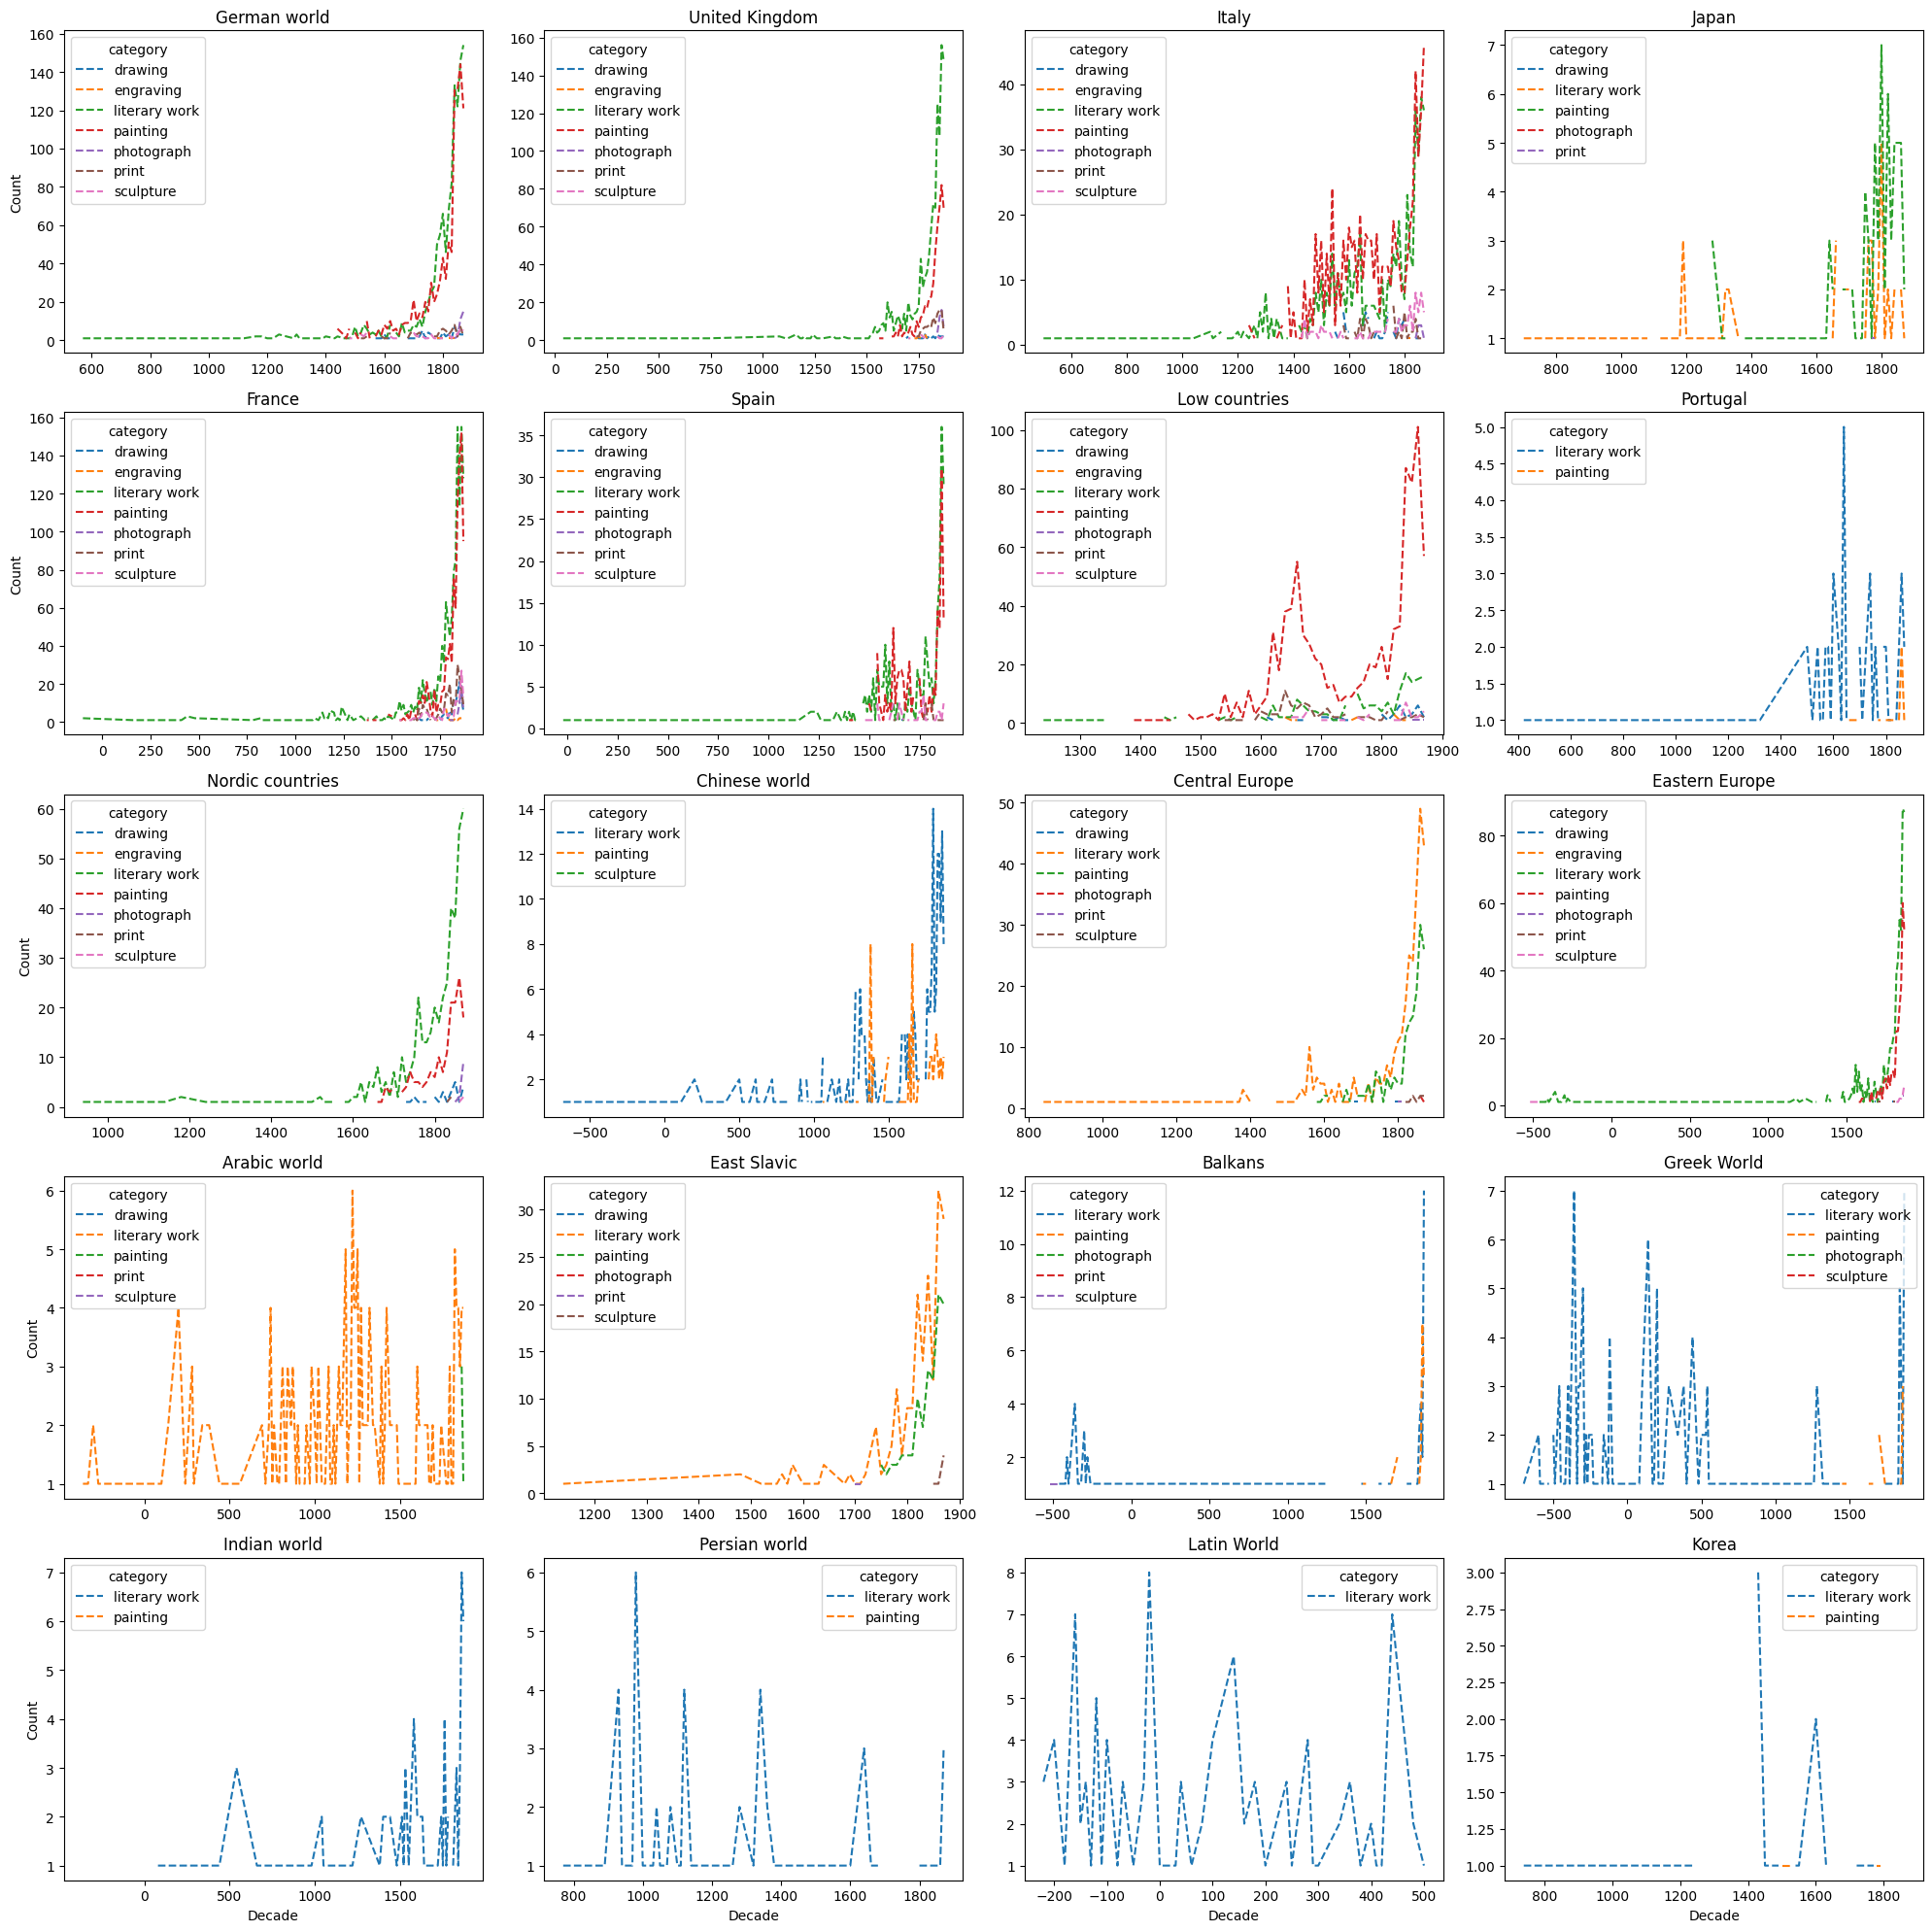

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_m is your DataFrame containing the data

# Get unique regions
unique_regions = df_m["region_name"].unique()

# Calculate number of rows and columns for subplots
num_rows = 5
num_cols = 4

# Calculate total number of subplots needed
num_plots = len(unique_regions)

# Calculate figure size
fig_width = 20  # Adjust this as needed
fig_height = num_rows * 4  # Adjust this as needed

# Create figure and axes
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Flatten the axes array to easily iterate over them
axs = axs.flatten()

# Iterate over each region
for i, region in enumerate(unique_regions):
    # Get the current axis
    ax = axs[i]
    
    # Filter data for the current region
    region_data = df_m[df_m["region_name"] == region]
    
    # Group by decade and gender, count individual_wikidata_id, and unstack
    grouped_data = region_data.groupby(["decade", "category"])["individual_wikidata_id"].count().unstack()
    
    # Plot the data
    grouped_data.plot(ax=ax, ls="--")
    
    # Set title for the subplot
    ax.set_title(region)
    
    # Hide x-axis label for all but the bottom row
    if i // num_cols != num_rows - 1:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Decade')
    
    # Hide y-axis label for all but the leftmost column
    if i % num_cols != 0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<Axes: xlabel='decade'>

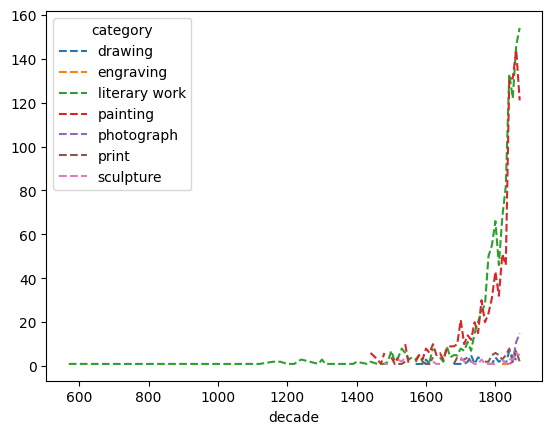

In [6]:
# Plot exisiting data
region = 'German world'
fig, ax = plt.subplots()

df_m[df_m["region_name"] == region].groupby(["decade", "category"])["individual_wikidata_id"].count().unstack().plot(
    ax=ax, ls="--")


## Varying Splines Analysis on Regions

In [7]:
import bambi as bmb
import arviz as az

iknots = knots[1:-1]

print(iknots)

#  Global Spline Analysis with Varying Intercepts for Region

sample = df_m.copy()
sample = sample.sample(1000, random_state=42)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


[-500. -200.  100.  400.  700. 1000. 1300. 1600.]


In [8]:
models = {}

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))}

gender_model = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + category + (1|region_name)', 
    sample[['decade','region_name', 'category', 'y']], 
    family='bernoulli', 
    priors=priors)

gender_model_fitted = gender_model.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro',idata_kwargs={"log_likelihood": True}

)  # important to run faster and sample more efficiently

models['category-model'] = gender_model_fitted
az.waic(models['category-model'])

Modeling the probability that y==1


Compiling...
2024-03-04 13:03:31.164806: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:02.909506
Sampling...
sample: 100%|██████████| 2000/2000 [00:35<00:00, 56.26it/s, 63 steps of size 9.00e-02. acc. prob=0.9

Computed from 4000 posterior samples and 1000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -632.18    12.39
p_waic       19.60        -

There has been a warning during the calculation. Please check the results.

In [18]:
?az.plot_forest

Signature:
az.plot_forest(
    data,
    kind='forestplot',
    model_names=None,
    var_names=None,
    filter_vars=None,
    transform=None,
    coords=None,
    combined=False,
    combine_dims=None,
    hdi_prob=None,
    rope=None,
    quartiles=True,
    ess=False,
    r_hat=False,
    colors='cycle',
    textsize=None,
    linewidth=None,
    markersize=None,
    legend=True,
    labeller=None,
    ridgeplot_alpha=None,
    ridgeplot_overlap=2,
    ridgeplot_kind='auto',
    ridgeplot_truncate=True,
    ridgeplot_quantiles=None,
    figsize=None,
    ax=None,
    backend=None,
    backend_config=None,
    backend_kwargs=None,
    show=None,
)
Docstring:
Forest plot to compare HDI intervals from a number of distributions.

Generate forest or ridge plots to compare distributions from a model or list of models.
Additionally, the function can display effective sample sizes (ess) and Rhats to visualize
convergence diagnostics alongside the distributions.

Parameters
----------
data 

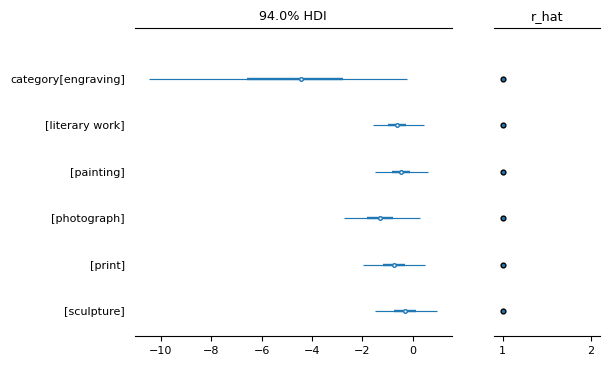

In [20]:
forest_plot = az.plot_forest(
    data=gender_model_fitted, 
    figsize=(6, 4), 
    var_names=["category"], 
    r_hat=True, 
    combined=True, 
    textsize=8,
    ess = True
    
)


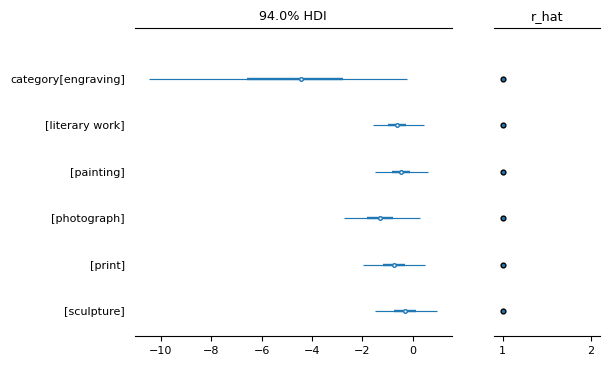

In [17]:
forest_plot[0].get_figure()

AttributeError: 'numpy.ndarray' object has no attribute 'get_figure'

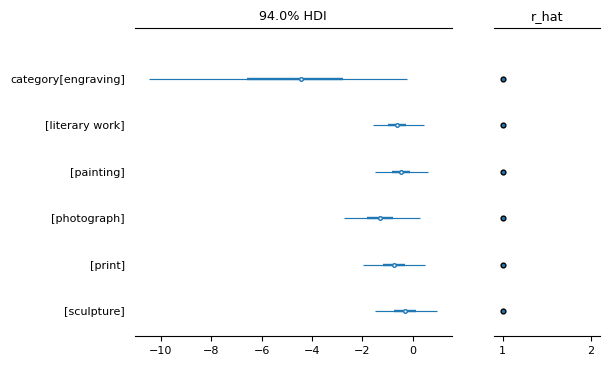

In [11]:

fig = forest_plot.get_figure()
fig.set_size_inches(8, 4)  # Adjust size as needed
fig.tight_layout()

In [34]:
# SECOND MODEL
priors_base_model = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

base_model = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    sample[['decade','region_name', 'y']], 
    family='bernoulli', 
    priors=priors_base_model)

base_model_fitted = base_model.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro',idata_kwargs={"log_likelihood": True}

)  # important to run faster and sample more efficiently


models['base-model'] = base_model_fitted
az.waic(models['base-model'])

Modeling the probability that y==1
Compiling...


/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:01.730343
Sampling...
sample: 100%|██████████| 2000/2000 [00:28<00:00, 70.19it/s, 31 steps of size 1.07e-01. acc. prob=0.92]
Sampling time = 0:01:57.850730
Transforming variables...
Transformation time = 0:00:00.146182
Computing Log Likelihood...
Log Likelihood time = 0:00:00.321829
/home/charles/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/

Computed from 4000 posterior samples and 1000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -631.09    12.14
p_waic       14.41        -

There has been a warning during the calculation. Please check the results.

/home/charles/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/charles/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/charles/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:

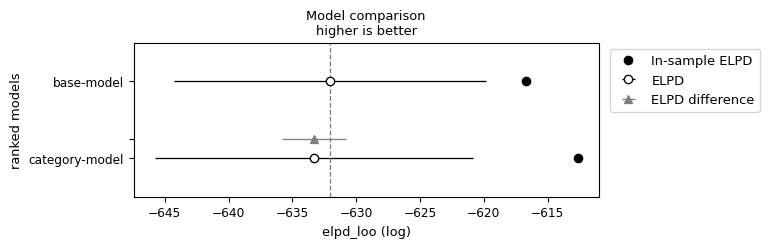

In [35]:
waic_compare = az.compare(models, ic='LOO')
az.plot_compare(waic_compare, insample_dev=True)

waic_compare = az.compare(models, ic='LOO')

In [ ]:
models['gender-model'] = gender_model_fitted
az.waic(models['gender-model'])

/home/charles/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 5000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -828.03    44.13
p_waic       20.40        -

There has been a warning during the calculation. Please check the results.

In [ ]:

priors_base_model = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

base_model = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    sample[['decade','region_name', 'y']], 
    family='bernoulli', 
    priors=priors_base_model)

base_model_fitted = base_model.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro',idata_kwargs={"log_likelihood": True}

)  # important to run faster and sample more efficiently

models['base-model'] = base_model_fitted
az.waic(models['base-model'])

Modeling the probability that y==1
Compiling...
/home/charles/.venv/lib/python3.10/site-packages/pymc/sampling/jax.py:687: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
Compilation time = 0:00:01.777280
Sampling...
sample: 100%|██████████| 2000/2000 [00:30<00:00, 66.18it/s, 31 steps of size 1.23e-01. acc. prob=0.91]
Sampling time = 0:02:04.280726
Transforming variables...
Transformation time = 0:00:00.148928
Computing Log Likelihood...
Log Likelihood time = 0:00:00.350430
/home/charles/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication 

Computed from 4000 posterior samples and 5000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -826.96    44.07
p_waic       19.27        -

There has been a warning during the calculation. Please check the results.

/home/charles/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


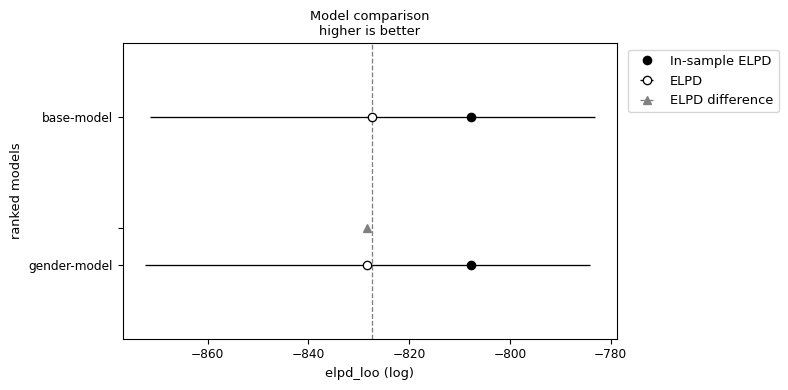

In [ ]:
waic_compare = az.compare(models, ic='LOO')

compare_plot = az.plot_compare(waic_compare, insample_dev=True)
fig = compare_plot.get_figure()
fig.set_size_inches(8, 4)  # Adjust size as needed
fig.tight_layout()

plt.show()

In [ ]:
waic_compare.to_csv('results/gender/model_comparison.csv')

fig.savefig('results/gender/compare_plot.png')

{'gender-model': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'base-model': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data}

In [ ]:
list_summaries = []

for key, item in models.items():
    res = az.summary(item)
    res['model'] = key
    list_summaries.append(res)

df_summaries = pd.concat([x for x in list_summaries])
df_summaries.to_csv('results/gender/model_results.csv')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,model
Intercept,-2.776,1.568,-5.334,0.334,0.241,0.172,50.0,376.0,1.07,gender-model
"bs(decade, knots=iknots, intercept=True)[0]",2.134,2.068,-1.214,6.334,0.284,0.202,49.0,609.0,1.06,gender-model
"bs(decade, knots=iknots, intercept=True)[1]",-0.640,2.716,-5.981,4.252,0.208,0.242,209.0,626.0,1.18,gender-model
"bs(decade, knots=iknots, intercept=True)[2]",1.682,1.816,-1.781,5.387,0.087,0.096,357.0,926.0,1.17,gender-model
"bs(decade, knots=iknots, intercept=True)[3]",-1.341,1.846,-4.553,2.222,0.237,0.168,76.0,1017.0,1.04,gender-model
...,...,...,...,...,...,...,...,...,...,...
1|region_name[Nordic countries],-0.323,0.211,-0.716,0.068,0.004,0.003,2598.0,2707.0,1.00,base-model
1|region_name[Persian world],0.104,0.340,-0.566,0.725,0.005,0.005,4583.0,2847.0,1.00,base-model
1|region_name[Portugal],0.166,0.313,-0.454,0.715,0.005,0.004,4451.0,2863.0,1.00,base-model
1|region_name[Spain],0.042,0.195,-0.324,0.411,0.004,0.003,2408.0,2310.0,1.00,base-model


In [ ]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

def plot_predictions(data, idata, model, region=None, ax=None, plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    if region is not None:
        data = data[data["region_name"] == region]
        new_data["region_name"] = [region] * 500
    new_data["decade"] = np.linspace(data["decade"].min(), data["decade"].max(), num=500)
    new_data = pd.DataFrame(new_data)

    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    y_hat = posterior_stacked["y_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(new_data["decade"], y_hat_mean, color=color, label=region)

    # Plot credibility bands
    ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="p(n_obs=2)")

[Text(0.5, 0, 'time'), Text(0, 0.5, 'p(n_obs=2)')]

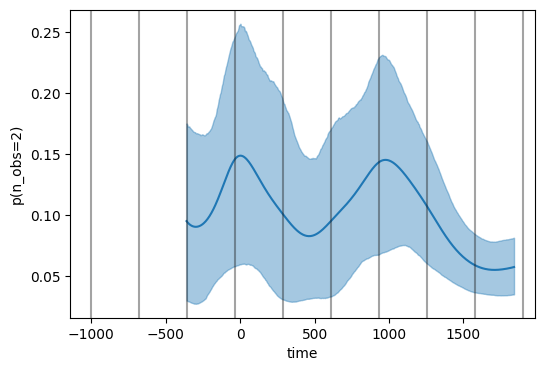

In [ ]:
region = 'Chinese world'
gender = 'male'

fig, ax = plt.subplots(figsize=(6, 4))  

new_data = {}
if region is not None:
    sample_fil = sample[sample["region_name"] == region]
    sample_fil = sample_fil[sample_fil['gender']==gender]
    new_data["region_name"] = [region] * 500
    new_data["gender"] = [gender] * 500


new_data["decade"] = np.linspace(sample_fil["decade"].min(), sample_fil["decade"].max(), num=500)
new_data = pd.DataFrame(new_data)
m_splines_vi.predict(p_splines_vs, data=new_data) # it predicts y = 1 based on the region_name and the decade

posterior_stacked = az.extract(p_splines_vs)

# Extract these predictions
y_hat = posterior_stacked["y_mean"] # probalility this is equal to 2

# Compute the mean of the predictions, plotted as a single line.
y_hat_mean = y_hat.mean("sample")

# Compute 94% credible intervals for the predictions, plotted as bands
hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

# Plot predicted line
color="C0"
ax.plot(new_data["decade"], y_hat_mean, color=color, label=region)

# Plot credibility bands
ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)


plot_knots(knots, ax)
ax.set(xlabel="time", ylabel="p(n_obs=2)")


In [ ]:
# probabiloty of y=1 based on the trained binomial model

In [ ]:
# Plot estimations

In [ ]:
sample

m_splines_vi # model
p_splines_vs # idata

region = 'Chinese world'
color="C0"
plot_knot_lines = True
logy=False

#fig, ax = plt.subplots()

new_data = {}
data = sample[sample["region_name"] == region]
obs_data = sample[sample["region_name"] == region]
new_data["decade"] = data["decade"].values 
new_data["region_name"] = [region] * len(data["decade"].values)
new_data = pd.DataFrame(new_data)


m_splines_vi.predict(p_splines_vs, data=new_data)

posterior_stacked = az.extract(p_splines_vs)

p = posterior_stacked["y_mean"].values
l = (2 * p) / (1 - p)
f0 = (1 / (l + (l**2) / 2))

decades = np.array(sorted(data["decade"].unique()))

N_est = np.zeros((len(decades), f0.shape[1]))
unseen = np.zeros((len(decades), f0.shape[1]))

n_obs_di = sample.loc[sample["decade"] == 1200, "individual_wikidata_id"].nunique()
mask = (new_data["decade"] == 1200).astype(int).values[:, None]


f0_di = (f0 * mask).sum(0)

S_di = n_obs_di + f0_di

N_est[i] = S_di

(58, 4000)

array([5., 5., 5., ..., 5., 5., 5.])

In [ ]:
def plot_estimations(data, idata, model, region=None, ax=None, logy=False, 
                     plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    data = data[data["region_name"] == region]
    data = data[data["region_name"] == region]   
    
    new_data["decade"] = data["decade"].values 
    new_data["region_name"] = [region] * len(data["decade"].values)
    
    new_data = pd.DataFrame(new_data)
    
    model.predict(idata, data=new_data) # we predict based on decade!

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    p = posterior_stacked["y_mean"].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))

    decades = np.array(sorted(data["decade"].unique()))
    
    N_est = np.zeros((len(decades), f0.shape[1]))
    unseen = np.zeros((len(decades), f0.shape[1]))
    
    for i, decade in enumerate(decades):
        n_obs_di = data.loc[data["decade"] == decade, "individual_wikidata_id"].nunique()
        mask = (new_data["decade"] == decade).astype(int).values[:, None]
        f0_di = (f0 * mask).sum(0)
        S_di = n_obs_di + f0_di # original n + unseen occurences for eveery decade
        N_est[i] = S_di
        unseen[i] = f0_di

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(N_est, [0.11, 0.89], axis=1) # because N_est is a distribution

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color="grey", label=region) # the mean is the result we give of the paper
    
    data[data["region_name"] == region].groupby("decade")["individual_wikidata_id"].count().plot(
        ax=ax, ls="--", color="red")
    
    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")
    
    return unseen, N_est, hdi_data, decades

(array([[  5.10906221,   4.11423841,   5.40424074, ...,   5.91605461,
           6.75489692,   7.02195762],
        [  4.23048847,   4.84440464,   4.58948955, ...,   5.15843714,
           5.37871364,   7.45458728],
        [  8.60118398,  10.14420235,   9.19838596, ...,  10.09046873,
          10.50711563,  14.7646874 ],
        ...,
        [624.17781235, 356.36972523, 463.95366093, ..., 578.17834989,
         480.84330734, 514.7762669 ],
        [452.01551031, 258.28420733, 333.67833043, ..., 397.98102509,
         353.8666185 , 331.32478948],
        [622.9463643 , 355.50708014, 455.86070299, ..., 515.74115731,
         495.08670233, 397.8843665 ]]),
 array([[  6.10906221,   5.11423841,   6.40424074, ...,   6.91605461,
           7.75489692,   8.02195762],
        [  5.23048847,   5.84440464,   5.58948955, ...,   6.15843714,
           6.37871364,   8.45458728],
        [ 10.60118398,  12.14420235,  11.19838596, ...,  12.09046873,
          12.50711563,  16.7646874 ],
        ...,


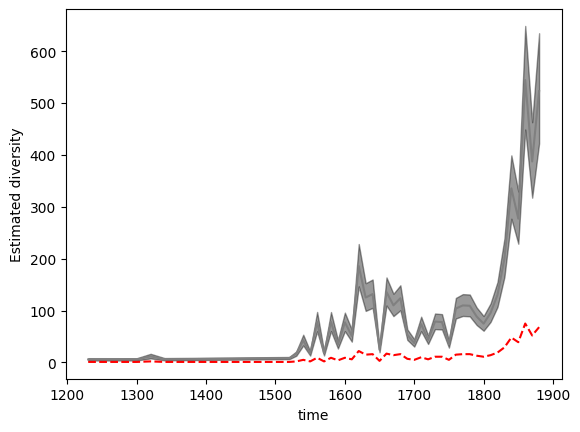

In [ ]:
plot_estimations(
    sample, p_splines_vs, m_splines_vi, "Low countries", color="k", plot_knot_lines=False, logy =False)

Text(0.5, 0.01, 'time')

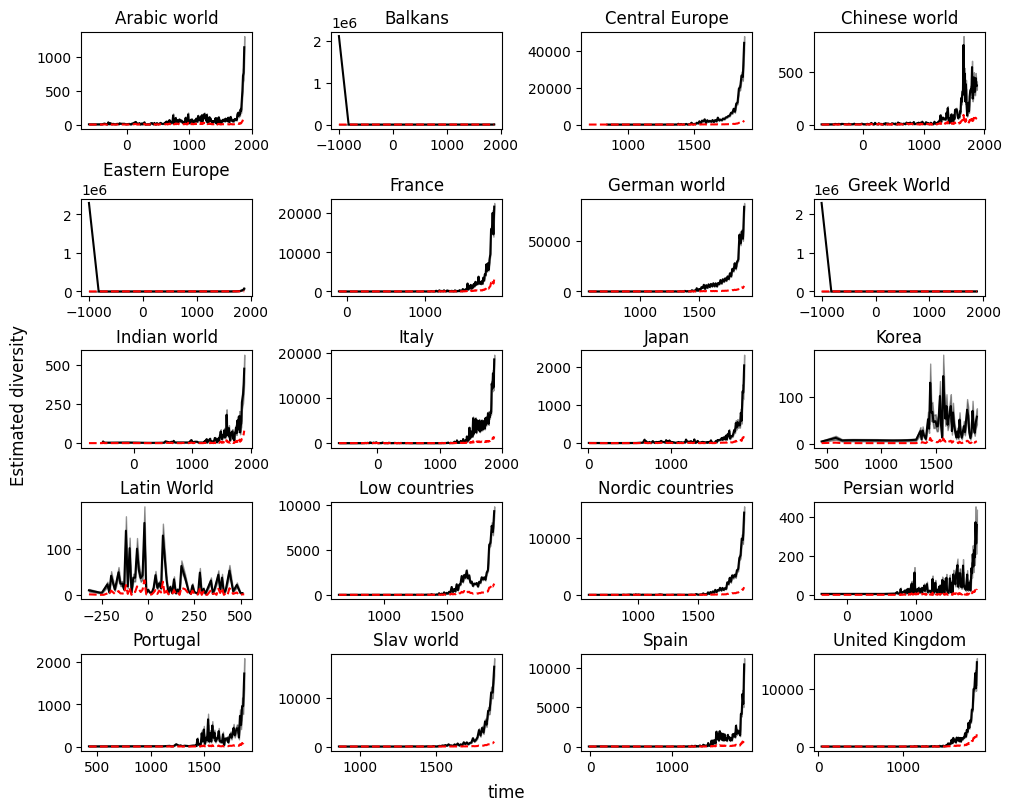

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

results = {}
for i, region in enumerate(sorted(df_m["region_name"].unique())):
    f0, N_est, hdi, decades = plot_estimations(
        sample, df, p_splines_vs, m_splines_vi, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")
    results[region] = f0, N_est, hdi, decades

fig.supylabel('Estimated diversity')
fig.supxlabel('time')


In [ ]:
fig.savefig('results/estimated_diversity_per_region.png', dpi=300)

In [ ]:
def plot_trend(decades, N_est, hdi_data, color="C0", label=None, ax=None, logy=False, figsize=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=label)

    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")

    return ax

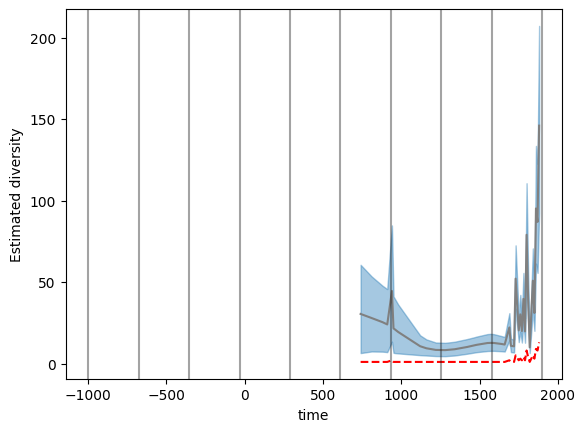

In [ ]:
region = 'Japan'

f0, N_est, hdi, decades = plot_estimations(sample, p_splines_vs, m_splines_vi, region=region, ax=None, logy=False, plot_knot_lines=True, color="C0")


(1000.0, 1900.0)

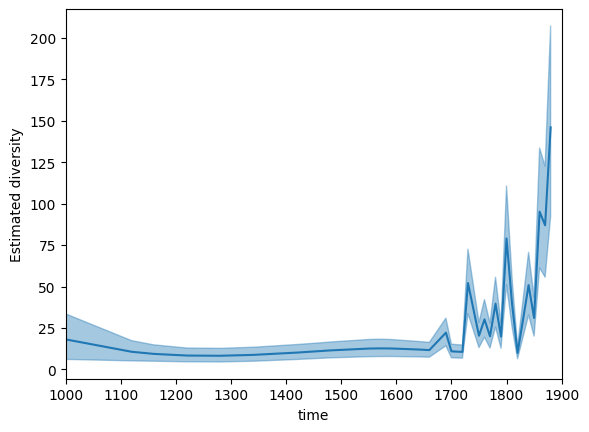

In [ ]:

ax = plot_trend(decades, N_est, hdi, label=region)
ax.set_xlim(1000, 1900)

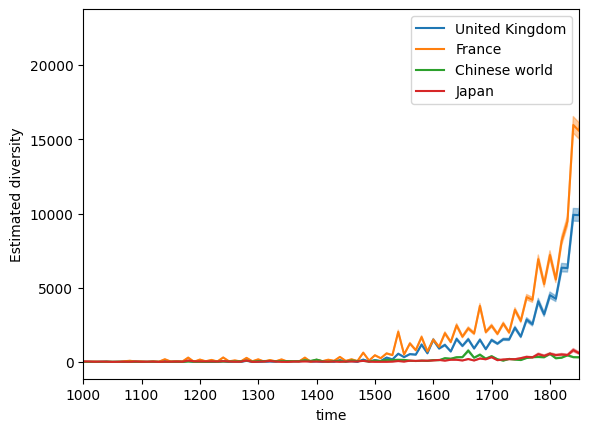

In [ ]:
regions = "United Kingdom", "France", "Chinese world", "Japan"

fig, ax = plt.subplots()
for i, region in enumerate(regions):
    f0, N_est, hdi, decades = results[region]
    ax = plot_trend(decades, N_est, hdi, color=f"C{i}", logy=False, label=region, ax=ax)
ax.set_xlim(1000, 1850)
ax.legend()

In [ ]:
import pickle

with open("regression-dump.pickle", "wb") as out:
    pickle.dump(results, out)

In [ ]:
table = []
for region in results:
    _, N_est, hdi, decades = results[region]
    N_est = N_est.mean(1)
    li, ui = hdi[0], hdi[1]
    print(N_est.shape, li.shape, ui.shape, decades.shape)
    table.append(pd.DataFrame({
        "N_est": N_est,
        "lower": li,
        "upper": ui,
        "decade": decades,
        "region": [region] * N_est.shape[0]
    }))
table = pd.concat(table)
table.head()

table.to_csv("results/estimations_charles.csv", index=False)
#table.to_csv("results/estimations.csv", index=False)
#table.to_csv("results/estimations_clean_gdp.csv", index=False)

(186,) (186,) (186,) (186,)
(137,) (137,) (137,) (137,)
(71,) (71,) (71,) (71,)
(189,) (189,) (189,) (189,)
(154,) (154,) (154,) (154,)
(113,) (113,) (113,) (113,)
(103,) (103,) (103,) (103,)
(199,) (199,) (199,) (199,)
(101,) (101,) (101,) (101,)
(166,) (166,) (166,) (166,)
(116,) (116,) (116,) (116,)
(70,) (70,) (70,) (70,)
(64,) (64,) (64,) (64,)
(71,) (71,) (71,) (71,)
(84,) (84,) (84,) (84,)
(109,) (109,) (109,) (109,)
(65,) (65,) (65,) (65,)
(57,) (57,) (57,) (57,)
(97,) (97,) (97,) (97,)
(94,) (94,) (94,) (94,)


,N_est,lower,upper,decade,region
0,4.386424,3.353913,5.531837,-610,Arabic world
1,4.906361,3.892610,6.024399,-520,Arabic world
2,5.188855,4.135945,6.329057,-400,Arabic world
3,15.920481,12.577407,19.575755,-360,Arabic world
4,5.431743,4.280787,6.679775,-330,Arabic world


<Axes: xlabel='decade'>

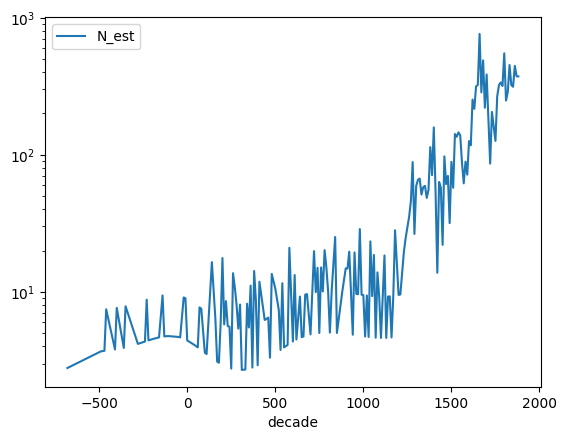

In [ ]:
test = table[table['region']=='Chinese world']
test.plot(x='decade', y ='N_est', logy=True)